## Experiment Description

Regression model for CFD data. All inputs to tuyere outputs (10x2).

To run interactively on the web got to:  https://rcalix1.github.io/ProbabilityDensityFunctionsFromNeuralNets/experiments/june2022/CFDallInputsToTuyere/index.html


In [1]:
################################################
##
## regression with DL for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 10000
batch_size = 5
learning_rate =  0.1    ## 0.01   ## 1e-5 

## probably need adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [2]:
CFD_raw_data = pd.read_csv('CFD.6.2022.csv') 

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


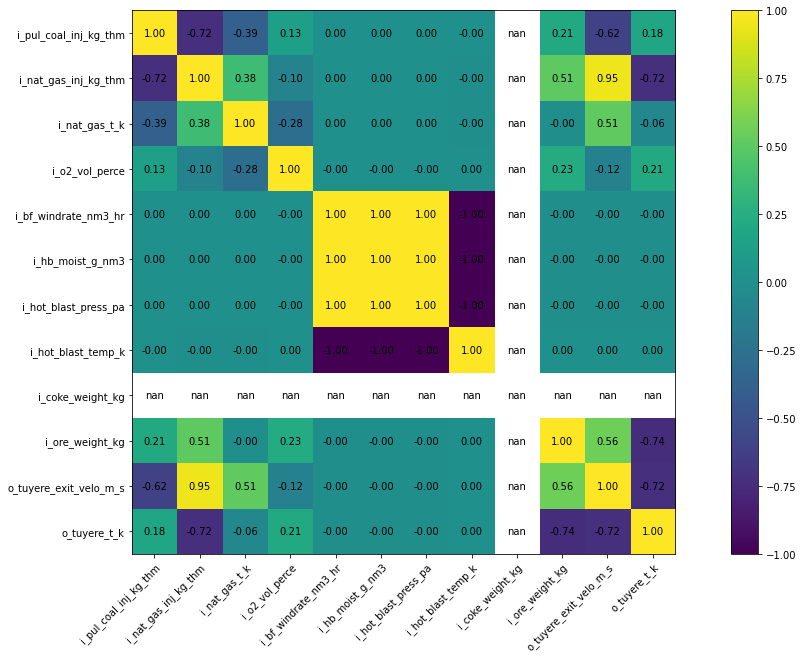

In [3]:

my_allInputs_tuyere_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
             'i_bf_windrate_nm3_hr','i_hb_moist_g_nm3','i_hot_blast_press_pa','i_hot_blast_temp_k',
             'i_coke_weight_kg','i_ore_weight_kg','o_tuyere_exit_velo_m_s','o_tuyere_t_k']



cm = np.corrcoef(CFD_raw_data[my_allInputs_tuyere_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_tuyere_names, column_names=my_allInputs_tuyere_names, figsize=(20, 10))
plt.show()

In [4]:
CFD_raw_data['i_coke_weight_kg']


0     24494
1     24494
2     24494
3     24494
4     24494
5     24494
6     24494
7     24494
8     24494
9     24494
10    24494
11    24494
12    24494
13    24494
14    24494
15    24494
16    24494
17    24494
18    24494
19    24494
20    24494
21    24494
22    24494
23    24494
24    24494
25    24494
26    24494
27    24494
28    24494
29    24494
30    24494
31    24494
32    24494
33    24494
34    24494
35    24494
36    24494
37    24494
38    24494
39    24494
40    24494
41    24494
42    24494
43    24494
44    24494
45    24494
46    24494
47    24494
48    24494
49    24494
50    24494
51    24494
52    24494
53    24494
54    24494
55    24494
Name: i_coke_weight_kg, dtype: int64

In [5]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))
print(headers_list[27])

for i, name in enumerate(headers_list):
    print((i, name))

['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth _m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_cohes_zone_root_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
28
o_shaft_n2_v_perc
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_coke_weight_kg')
(10, 'i_ore_weight_kg')
(11, 'o_tuyere_exit_velo_m_s')
(12, 'o_tuyere_t_k')
(13, 'o_raceway

In [6]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[ 1.          0.         37.9        ...  0.1941631   0.0438327
   0.5448123 ]
 [ 2.          0.         37.9        ...  0.2186134   0.04034286
   0.5149459 ]
 [ 3.          0.         37.9        ...  0.2353341   0.03772617
   0.4849808 ]
 ...
 [54.         70.          0.         ...  0.2279862   0.02182447
   0.5193577 ]
 [55.         70.          0.         ...  0.2387356   0.02094042
   0.4884186 ]
 [56.         70.          0.         ...  0.2464429   0.01986916
   0.4608655 ]]
(56, 28)


## Experiment description

Train_X.........(44, 10)

Train_y.........(44, 2)

Test_X.........(12, 10)

Test_y.........(12, 2)

In [7]:
#######################################################


def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(model(X_train_tr), y_train_tr))
    print('Training R**2:', r2_score(y_train_tr.numpy(), model(X_train_tr).detach().numpy()))
    
#######################################################

In [8]:
#######################################################

input_indeces  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
output_indeces = [11, 12 ]                            ## tuyere

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56, 10)
(56, 2)
(44, 10)
(12, 10)
(44, 2)
(12, 2)


In [9]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [10]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [11]:
#######################################################
## Linear Regression

class LinRegNet(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 2) 

    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        return x


#######################################################
## MLP

class SimpleNet(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 8)
        self.act1    = nn.Sigmoid() 
        self.linear2 = nn.Linear(8, 2)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x
    
#############################################################
## DL


class DL_Net(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 10)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(10, 8)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(8, 2)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        return x
    
#############################################################


class SimpleNet_Dropout(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 8)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.25)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    
#############################################################

class DL_Net_Dropout(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 10)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(10, 8)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.25)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x
    
#############################################################


class DL_Net_Big_Dropout(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 32)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(32, 16)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.25)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x
    
#############################################################


In [12]:
#############################################################
## model = LinRegNet()
## model = SimpleNet()
## model = DL_Net()

## model = SimpleNet_Dropout()
model = DL_Net_Dropout()
## model = DL_Net_Big_Dropout()

## opt = torch.optim.SGD(   model.parameters(), lr=learning_rate  )
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

#############################################################

In [13]:
fit(N_EPOCHS, model, loss_fn, opt)

Training loss: tensor(299.2857, grad_fn=<MseLossBackward0>)
Training R**2: -0.007108551936903518


In [14]:
for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds = model(X_test_tr[i])
    np_pred = preds.detach().numpy()
    np_real = y_test_tr[i].detach().numpy()
    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))

**************************************************
preds, real
(138.22687, 133.4865)
(1412.3755, 1440.96)
**************************************************
preds, real
(137.61923, 133.9054)
(1412.5371, 1444.46)
**************************************************
preds, real
(136.24706, 157.34734)
(1413.4242, 1367.4567)
**************************************************
preds, real
(137.30241, 137.1573)
(1413.7347, 1428.1643)
**************************************************
preds, real
(138.33635, 140.9279)
(1412.5294, 1419.4747)
**************************************************
preds, real
(137.89746, 128.57207)
(1414.251, 1429.0322)
**************************************************
preds, real
(138.09729, 129.75002)
(1412.248, 1423.4567)
**************************************************
preds, real
(137.55098, 144.69981)
(1414.1823, 1406.878)
**************************************************
preds, real
(136.43405, 129.83923)
(1414.1477, 1418.1798)
******************************

In [15]:
print('Test loss:', loss_fn(model(X_test_tr), y_test_tr))
print('Testing R**2:', r2_score(y_test_tr.numpy(), model(X_test_tr).detach().numpy()))

Test loss: tensor(294.9959, grad_fn=<MseLossBackward0>)
Testing R**2: -0.12880050937771104


In [16]:


model.eval()

dummy_input = torch.randn(1, 10)


input_names = ["input1"]
output_names = ["output1"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/CFDallInputsToTuyere.onnx", 
  verbose=False, 
  input_names=input_names,
  output_names=output_names
)



In [17]:
print(X_test_tr[5] )
preds = model(    X_test_tr[5]     )
print(    preds)
print(    y_test_tr[5]             )

tensor([   38.0000,     0.0000,   300.0000,    27.0000, 308750.3750,    12.1540,
        359906.3125,  1459.8170, 24494.0000, 87618.0156])
tensor([ 137.3301, 1413.5590], grad_fn=<AddBackward0>)
tensor([ 128.5721, 1429.0322])
